In [1]:
import os
import requests
from dotenv import load_dotenv

load_dotenv()
SILICONFLOW_API_KEY = os.getenv("SILICONFLOW_API_KEY")

In [2]:
import re

def clean_text(text):
	"""
	清理文本内容，去除Wiki标记和多余格式。
	"""
	text = re.sub(r'\{\{对话\|([^|]+)\|([^}]+)\}\}', lambda m: f"{m.group(1)}：{m.group(2).replace('<br>', ' ')}", text)

	text = re.sub(r'\{\{(?:xh|xl|状态|物品|任务|货币|版本|地图)\|([^|}]*)[^}]*\}\}', r'\1', text)

	text = re.sub(r'\{\{Role\|[^|]+\|([^}]+)\}\}', r'\1', text)

	text = re.sub(r'\{\{[^}]+text=([^|}]+)[^}]*\}\}', r'\1', text)

	text = re.sub(r'\{\{黑幕\|([^}]+)\}\}', r'\1', text)
	text = re.sub(r'<span[^>]*class="blackcover"[^>]*>(.*?)</span>', r'\1', text)

	text = re.sub(r'\[\[(?:[^|\]]+\:)?([^|\]]+\|)?([^\]]+)\]\]', lambda m: m.group(2) if m.group(2) else m.group(1).split('|')[0], text)

	text = re.sub(r'<[^>]+>', '', text)
	text = re.sub(r"'''", '', text) 
	text = re.sub(r"''", '', text)

	text = re.sub(r'\{\{[^}]+\}\}', '', text)

	text = re.sub(r'={2,}([^=]+)={2,}', r'\1', text)
	text = re.sub(r'^\*+', '· ', text, flags=re.MULTILINE)

	lines = [line.strip() for line in text.splitlines() if line.strip()]
	return "\n".join(lines)

def process_docs(input_dir, output_dir):
	"""
	处理输入目录中的所有文本文件，清理内容后保存到输出目录。
	"""
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

	for filename in os.listdir(input_dir):
		if filename.endswith(".txt"):
			with open(os.path.join(input_dir, filename), 'r', encoding='utf-8') as f:
				content = f.read()
			
			clean_content = clean_text(content)
			
			with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
				f.write(clean_content)
			print(f"成功清洗: {filename}")

In [3]:
RAW_DIR = "./docs_raw"
CLEAN_DIR = "./docs_clean"

if os.path.exists(RAW_DIR):
	process_docs(RAW_DIR, CLEAN_DIR)
	print("--- 清洗完成 ---")
else:
	print(f"错误: 找不到源文件夹 {RAW_DIR}")

成功清洗: doc1.txt
成功清洗: doc2.txt
--- 清洗完成 ---


In [4]:
# 准备向量化与 RAG 调用
import requests
import json
import numpy as np


In [5]:
# BGE-M3 向量化函数
def get_embedding(text):
	"""调用 BGE-M3 获取文本向量"""
	url = "https://api.siliconflow.cn/v1/embeddings"
	headers = {
		"Authorization": f"Bearer {SILICONFLOW_API_KEY}",
		"Content-Type": "application/json"
	}
	payload = {
		"model": "BAAI/bge-m3",
		"input": [text]
	}
	resp = requests.post(url, headers=headers, json=payload)
	data = resp.json()
	return data["data"][0]["embedding"]

# 测试
sample_text = "Agentic RAG 是结合检索与生成的系统"
vector = get_embedding(sample_text)
print(f"向量长度: {len(vector)}")


向量长度: 1024


In [6]:
def chunk_text(text, min_len=50, max_len=500):
	"""
	按换行符切分文本，每块长度控制在 min_len ~ max_len 之间。
	
	- min_len: 避免太短的段落
	- max_len: 避免超过模型 token 限制
	"""
	lines = [line.strip() for line in text.split("\n") if line.strip()]
	chunks = []
	current_chunk = ""
	
	for line in lines:
		if len(current_chunk) + len(line) + 1 <= max_len:
			current_chunk += line + "\n"
		else:
			if len(current_chunk) >= min_len:
				chunks.append(current_chunk.strip())
			current_chunk = line + "\n"
	
	if current_chunk.strip():
		chunks.append(current_chunk.strip())
	
	return chunks


In [7]:
from chromadb import Client, PersistentClient
from chromadb.config import Settings
import os

DB_DIR = "./chroma_db"
COLLECTION_NAME = "text_chunks_small"

client = PersistentClient(path=DB_DIR)

# 判断是否已有可用向量库
db_exists = os.path.exists(DB_DIR)
collection_names = [c.name for c in client.list_collections()]

if db_exists and COLLECTION_NAME in collection_names:
    collection = client.get_collection(name=COLLECTION_NAME)
    if collection.count() > 0:
        print(f"检测到本地 ChromaDB，已包含 {collection.count()} 个向量，跳过构建")
    else:
        print("集合存在但为空，开始构建向量库")
else:
    print("未检测到本地向量库，开始构建")

# 只有在需要时才构建
if not (db_exists and COLLECTION_NAME in collection_names and collection.count() > 0):
    if COLLECTION_NAME in collection_names:
        collection = client.get_collection(name=COLLECTION_NAME)
    else:
        collection = client.create_collection(name=COLLECTION_NAME)

    for fname in os.listdir(CLEAN_DIR):
        if not fname.endswith(".txt"):
            continue

        with open(os.path.join(CLEAN_DIR, fname), "r", encoding="utf-8") as f:
            text = f.read()

        for i, chunk in enumerate(chunk_text(text)):
            vec = get_embedding(chunk)
            if vec is not None:
                collection.add(
                    ids=[f"{fname}_part{i+1}"],
                    documents=[chunk],
                    embeddings=[vec]
                )

    
    print(f"ChromaDB 向量库构建完成，共 {collection.count()} 个文档块")


检测到本地 ChromaDB，已包含 81 个向量，跳过构建


In [8]:
import requests
import numpy as np

# 检索 + BGE-Reranker 重排
def retrieve(query, top_k=5):
    query_vec = get_embedding(query)
    
    # ChromaDB 初步检索 top_k
    results = collection.query(
        query_embeddings=[query_vec],
        n_results=top_k
    )
    
    # 构建 top_docs
    top_docs = []
    if results['documents']:
        for doc_id, text in zip(results['ids'][0], results['documents'][0]):
            top_docs.append({
                "id": doc_id,
                "text": text
            })
    
    # 调用 BGE-Reranker 进一步重排
    url = "https://api.siliconflow.cn/v1/rerank"
    headers = {
        "Authorization": f"Bearer {SILICONFLOW_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "BAAI/bge-reranker-v2-m3",
        "query": query,
        "documents": [doc["text"] for doc in top_docs]
    }
    resp = requests.post(url, headers=headers, json=payload)
    data = resp.json()
    
    if "results" in data and data["results"]:
        # 按相关性降序排序
        sorted_indices = [
            item["index"] for item in sorted(
                data["results"],
                key=lambda x: x["relevance_score"],
                reverse=True
            )
        ]
        reranked_docs = [top_docs[i] for i in sorted_indices]
    else:
        reranked_docs = top_docs

    return reranked_docs

# 测试
top_docs = retrieve("什么是 Agentic RAG？")
for i, doc in enumerate(top_docs):
    print(f"Top-{i+1} 文档: {doc['id']}")


Top-1 文档: doc1.txt_part44
Top-2 文档: doc1.txt_part73
Top-3 文档: doc1.txt_part38
Top-4 文档: doc1.txt_part17
Top-5 文档: doc1.txt_part2


In [9]:
# 调用 DeepSeek-R1 生成答案（可选 RAG）
def generate_answer(query, context_docs=None):
    url = "https://api.siliconflow.cn/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {SILICONFLOW_API_KEY}",
        "Content-Type": "application/json"
    }

    if context_docs:  # 有参考文档，使用 RAG
        context_text = "\n".join([doc["text"] for doc in context_docs])
        prompt = f"""
请根据以下参考内容回答问题，只输出最终答案，不要输出任何思考过程或分析步骤。
严格按照条列格式输出，禁止任何解释或推理。

【参考内容】
{context_text}

【问题】
{query}

【要求】
- 输出必须为 Markdown 条列形式，并且尽可能简洁
- 不允许出现任何“我认为 / 首先 / 我需要思考 / 接下来 / 为了确认”等语言
"""
    else:  # 没有参考文档，直接回答问题
        prompt = f"""
请回答以下问题，只输出最终答案，不要输出任何思考过程或分析步骤。
严格按照条列格式输出，禁止任何解释或推理。

【问题】
{query}

【要求】
- 输出必须为 Markdown 条列形式，并且尽可能简洁
- 不允许出现任何“我认为 / 首先 / 我需要思考 / 接下来 / 为了确认”等语言
"""

    payload = {
        "model": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
        "messages": [
            {
                "role": "system",
                "content": "你是一个只输出最终答案的模型。输出必须完全遵守 Markdown 条列格式，禁止输出任何过程性思考、推理或解释段落。"
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "max_tokens": 2000,
        "temperature": 0
    }

    resp = requests.post(url, headers=headers, json=payload)
    content = resp.json()["choices"][0]["message"]["content"]

	# 提取最终答案，去除可能的思考标签
    if "</think>" in content:
        answer = content.split("</think>")[-1].strip()
    else:
        answer = content.strip()

    return answer


In [10]:


# 测试
answer_with_docs = generate_answer("什么是 Agentic RAG？", top_docs)
print("生成答案（RAG）:\n", answer_with_docs)

print("-" * 50)

answer_without_docs = generate_answer("什么是 Agentic RAG？")
print("生成答案（无 RAG）:\n", answer_without_docs)


生成答案（RAG）:
 根据提供的参考内容，无法找到“Agentic RAG”的定义。
--------------------------------------------------
生成答案（无 RAG）:
 **Agentic RAG** 是一种结合了主动性（agent）和检索增强生成（RAG）的方法，通过主动查询和检索相关知识库或数据源，生成更准确和相关的回答。


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate

# 初始化指标
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

def evaluate_answer(pred_answer, reference_answer, visualize=True):
    """
    使用 ROUGE 评估模型答案
    如果 visualize=True，会直接画图
    """
    results = rouge.compute(predictions=[pred_answer], references=[reference_answer])

    if visualize:
        # 提取主要指标
        metrics = ['rouge1', 'rouge2', 'rougeL']
        scores = [results[m] for m in metrics]

        plt.figure(figsize=(6,4))
        sns.barplot(x=metrics, y=scores, hue=metrics, palette="Blues_d")
        plt.ylim(0,1)
        plt.title("ROUGE Scores")
        plt.ylabel("Score")
        plt.show()

    return results


def evaluate_answer_bert(pred_answer, reference_answer, visualize=True, lang="zh"):
    """
    使用 BERTScore 评估语义相似度
    如果 visualize=True，会直接画图
    """
    results = bertscore.compute(predictions=[pred_answer], references=[reference_answer], lang=lang)

    if visualize:
        metrics = ['precision', 'recall', 'f1']
        scores = [results[m][0] for m in metrics]  # bertscore 返回列表
        plt.figure(figsize=(6,4))
        sns.barplot(x=metrics, y=scores, hue=metrics, palette="Greens_d")
        plt.ylim(0,1)
        plt.title("BERTScore Scores")
        plt.ylabel("Score")
        plt.show()

    return results


In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from numpy import dot
from numpy.linalg import norm

# 定义状态结构
class State(TypedDict, total=False):
    query: str
    context_docs: list
    need_rag: bool
    answer: str
    answer_correct: bool
    step: int
    max_steps: int

# 创建图
graph_builder = StateGraph(State)

# 实时打印状态
def log_hook(node_name, state):
    step = state.get("step", 0)
    need_rag = state.get("need_rag", None)
    answer = state.get("answer", None)
    answer_correct = state.get("answer_correct", None)
    context_docs = state.get("context_docs", [])

    print(f"\n[Node] {node_name}")
    print(f"Step: {step}")
    if need_rag is not None:
        print(f"Need RAG: {need_rag}")
    if context_docs:
        print(f"Docs ({len(context_docs)}): {[doc['text'][:50] for doc in context_docs]}")
    if answer is not None:
        print(f"Answer: {answer}")
    if answer_correct is not None:
        print(f"Answer correct: {answer_correct}")

# 记录当前的论数
def step_node(state: State):
    step = state.get("step", 0) + 1
    print(f"\n========== Round {step} ==========")
    return {"step": step}

SIM_THRESHOLD = 0.5

def cosine_similarity(vec1, vec2):
    """计算两个向量的余弦相似度"""
    if vec1 is None or vec2 is None:
        return 0.0
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2) + 1e-8)

# 判断是否需要 RAG
def need_rag_node(state: State):
    """
    使用向量相似度判断是否需要 RAG：
    - query 与 top_docs 的向量余弦相似度 >= SIM_THRESHOLD → 需要 RAG
    - 否则 → 不需要 RAG
    """
    query = state.get("query", "")
    # 检索 top_k 文档
    top_docs = retrieve(query)
    state["context_docs"] = top_docs  # 保存文档以供 RAG 节点使用

    # query 向量
    query_vec = get_embedding(query)

    # 计算文档向量相似度
    max_sim = 0.0
    for doc in top_docs:
        # 假设文档里保存了 embedding，如果没有就生成
        if "embedding" not in doc:
            doc["embedding"] = get_embedding(doc["text"])
        sim = cosine_similarity(query_vec, np.array(doc["embedding"]))
        max_sim = max(max_sim, sim)

    # 如果最大相似度大于阈值，则认为需要 RAG
    need_rag = max_sim >= SIM_THRESHOLD

    print(f"[Vector RAG Decision] max_sim={max_sim:.3f}, threshold={SIM_THRESHOLD}, need_rag={need_rag}")
    return {"need_rag": need_rag}

# RAG 节点
def rag_node(state: State):
    query = state.get("query", "")
    docs = state.get("context_docs", [])

    print(f"[RAG] Using {len(docs)} docs")
    for i, doc in enumerate(docs, 1):
        preview = doc["text"][:200].replace("\n", " ")
        print(f"  Doc-{i}: {preview} ...")

    answer = generate_answer(query, context_docs=docs)
    print(f"[Answer - RAG]\n{answer}\n")

    return {"answer": answer}

# 直接回答节点
def direct_answer_node(state: State):
    query = state.get("query", "")
    answer = generate_answer(query)

    print("[Answer - Direct]")
    print(answer, "\n")

    return {"answer": answer}

# 判断是否满足需求
def check_correct_node(state: State):
    correct = check_answer_correct(
        query=state.get("query"),
        answer=state.get("answer"),
        context_docs=state.get("context_docs"),
        need_rag=state.get("need_rag")
    )

    print(f"[Check] Answer correct: {correct}")

    return {"answer_correct": correct}

def correct_routing(state: State):
    if state.get("answer_correct", False):
        return "end"

    if state.get("step", 0) >= state.get("max_steps", 3):
        return "end"

    return "retry"


In [13]:
graph_builder.add_node("step", step_node)
graph_builder.add_node("need_rag", need_rag_node)
graph_builder.add_node("rag", rag_node)
graph_builder.add_node("direct_answer", direct_answer_node)
graph_builder.add_node("check_correct", check_correct_node)

graph_builder.add_edge(START, "step")
graph_builder.add_edge("step", "need_rag")

graph_builder.add_conditional_edges(
    "need_rag",
    lambda s: "rag" if s.get("need_rag") else "direct_answer"
)

graph_builder.add_edge("rag", "check_correct")
graph_builder.add_edge("direct_answer", "check_correct")

graph_builder.add_conditional_edges(
    "check_correct",
    correct_routing,
    {
        "end": END,
        "retry": "step"
    }
)

graph = graph_builder.compile()

In [14]:
def check_answer_correct(query, answer, need_rag, context_docs=None, threshold=0.75):
    """
    判断答案是否正确：
    - 如果有 RAG 文档 context_docs，则用向量相似度量化覆盖度
    - 如果没有 context_docs，则交给大模型判断 YES/NO

    参数：
    - query: 用户提问
    - answer: 模型生成的答案文本
    - context_docs: 可选，RAG 文档列表，每个元素包含 'text'
    - threshold: 相似度阈值（0~1），用于判断答案是否覆盖知识库

    返回：
    - True  表示答案正确
    - False 表示答案不正确
    """
    import numpy as np

    # 没有参考文档，交给大模型判断
    if need_rag == False or not context_docs or len(context_docs) == 0:
        prompt = f"""
你是一个严格的评判模型。
请判断以下回答是否正确回答了问题。
严格要求：
- 只输出 YES 或 NO，必须大写
- 不允许任何解释或条列
- 不允许输出其他内容

问题: {query}
回答: {answer}
"""
        judgement = generate_answer(prompt)
        return "YES" in judgement.upper()

    # 有参考文档，使用向量相似度判断
    def cosine_similarity(vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    answer_vec = np.array(get_embedding(answer))
    doc_vecs = [np.array(get_embedding(doc["text"])) for doc in context_docs]

    sims = [cosine_similarity(answer_vec, v) for v in doc_vecs]
    max_sim = max(sims)

    # 相似度高于阈值 → 答案正确
    return max_sim >= threshold


In [15]:
def run_query_with_react(query: str, max_iters: int = 3):
    """
    每轮循环打印 ReAct 当前决策：
    - 是否需要 RAG
    - 当前回答节点
    - 当前答案
    """
    top_docs = retrieve(query)
    state = {
        "query": query,
        "context_docs": top_docs,
        "step": 0,
        "max_steps": max_iters
    }
    output = graph.invoke(state, post_node_hook=log_hook)
    return output.get("answer", "")



========== Round 1 ==========
[Vector RAG Decision] max_sim=0.358, threshold=0.5, need_rag=False
[Answer - Direct]
**Agentic RAG** 是一种结合检索和生成模型的主动式方法，用于生成更高质量的文本。它通过主动选择最相关的上下文来增强生成过程。 

[Check] Answer correct: True
最终答案:
 **Agentic RAG** 是一种结合检索和生成模型的主动式方法，用于生成更高质量的文本。它通过主动选择最相关的上下文来增强生成过程。


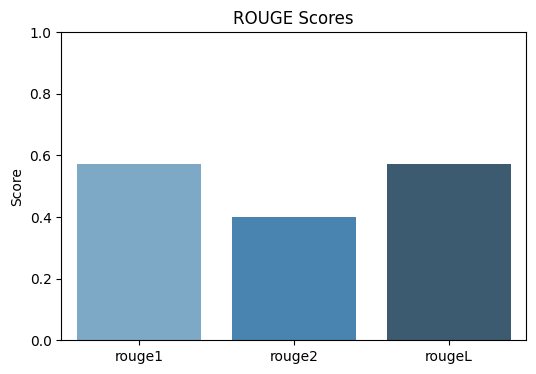

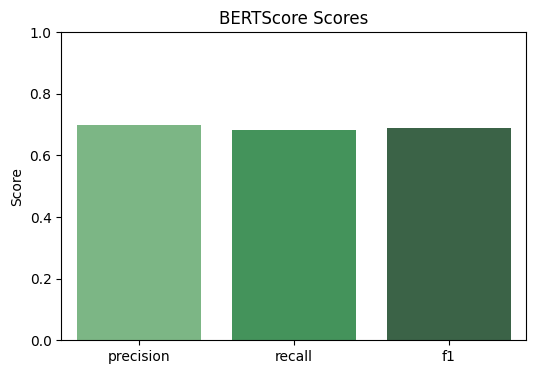

ROUGE 测评结果: {'rouge1': np.float64(0.5714285714285715), 'rouge2': np.float64(0.4), 'rougeL': np.float64(0.5714285714285715), 'rougeLsum': np.float64(0.5714285714285715)}
BERTScore 测评结果: {'precision': [0.6982237696647644], 'recall': [0.6826298236846924], 'f1': [0.6903387308120728], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [16]:
final_answer = run_query_with_react("什么是 Agentic RAG？")
print("最终答案:\n", final_answer)

reference = """
Agentic RAG 是一种引入了智能代理（AI Agent）能力的 RAG 架构，它不仅能检索信息，还能通过自我思考、多步推理、工具调用及结果评估，自主优化查询路径以提供更精准的答案。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)


========== Round 1 ==========
[Vector RAG Decision] max_sim=0.502, threshold=0.5, need_rag=True
[RAG] Using 5 docs
  Doc-1: · （物品名）+n：宝箱中开出老板要求的稀有罕见物品后额外追加的工资，如：通过G14陈旧的金毗罗鳄革地图进入惊奇百宝城取得的惊奇补剂或绚烂华丽的羽毛，简称补剂（剂）/羽毛（毛）；通过G15陈旧的蛇牛革地图进入厄尔庇斯育体宝殿取得的灼热的火角；通过G17陈旧的狞豹革地图进入加加财富天坑取得的幻梦武器箱以及各种仅限宝物库产出的其它物品。 ·  底+n：成功突破宝物库的最终区域后额外追加的工资。底层团灭 ...
  Doc-2: · 小黑衣/小红衣：指通过神秘印章和大马士革织物兑换的麒麟/朱红补正装。 · 校服：一般也称为AF，是一系列仅限特定职业专属、反映职业特色的装备。对于战斗职业，一般情况下是指对应版本的职业任务中可以获得的最终套装。对于制作采集职业则是通过工票兑换获得的职业限定装备。 寻宝 · G17/G_：陈旧的狞豹革地图，来源于日文端道具名古ぼけた地図G17 · G1~G17详见藏宝图。 · 在国际服或特定语境 ...
  Doc-3: · 由于藏宝图持有限制（除陈旧的特殊地图可堆叠，其余藏宝图均只能持有一张），通常以三张为一组，即一张已解读在任务道具一栏，一张未解读在背包普通道具栏，一张未解读放在陆行鸟鞍囊。 · 按照老板队的约定俗成，只有老板才可以在对宝箱中开出的稀有物品掷骰时选择需求，其他人可选择贪婪或放弃。在有特别标注的情况下可以选择需求。为防止误roll老板所需造成惨案，还请注意沟通确认，以实际情况为准！ · __t__ ...
  Doc-4: · NQ：Normal Quality，普通品质物品 · HQ：High Quality，高品质物品 · 吉田概率学：98%hq的概率下制作成nq、99%采集成功率6连空、仓促5连炸等一系列低概率事件频繁发生，又因为游戏制作人为吉田P，因此被调侃为“吉田概率学”类似梗如：G胖不会数3 · 林%：在国服某次访谈中，曾提及道具掉率等数值都交由道具组林先生负责，因此当时一度称吉田概率学为“0%”的谐音“ ...
  Doc-5: · 老板/老板队：为了得到副本中某些物

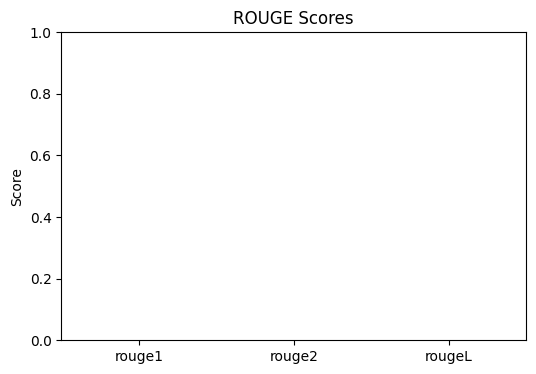

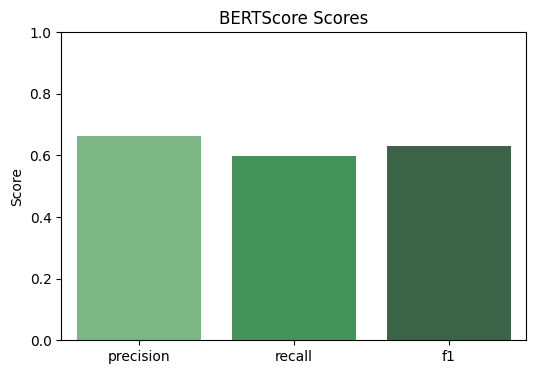

ROUGE 测评结果: {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}
BERTScore 测评结果: {'precision': [0.6642935872077942], 'recall': [0.5994750261306763], 'f1': [0.6302220225334167], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [17]:
final_answer = run_query_with_react("‘G17 6张 底30w 挂件v10’是什么意思？")
print("最终答案:\n", final_answer)

reference = """
寻宝陈旧的狞豹革地图，一共挖六张，打工仔底薪为30万游戏币，如果进宝物库成功突破最终区域的情况下给贡献藏宝图的队长10万金币。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)



========== Round 1 ==========
[Vector RAG Decision] max_sim=0.543, threshold=0.5, need_rag=True
[RAG] Using 5 docs
  Doc-1: · 狂战：愤怒的人造人——新月狂战士概率掉落灵魂碎晶：狂战士 · 预言：双足狮人——跃立狮概率掉落灵魂碎晶：预言师 · 猎人：黑色连队概率掉落灵魂碎晶：猎人 · 28/27：指金币队在地图左下角刷怪物的等级 · 跑刀：跑全图开铜/银箱子。 · 幸福罐：瑟瑟发抖的魔法罐和幸福的魔法罐魔法罐可以带领玩家找到隐藏宝箱获取丰厚奖励奖励魔晶石和魔法棱晶（礼花彩带） 副本简称 ·  假火/风/土：火神/风神/ ...
  Doc-2: · 极月读：第二次极月读的月相属性必定与第一次相反。 · 深宵换装：第二次极月读的深宵换装必定为长枪。 · 黄泉之舞：无读条带有明显特效的全屏AOE，为自身赋予死刀流，进入P4。 P4 · 攻击：月读的普通攻击为对一仇目标的物理伤害。 · 月刀左斩/月刀右斩：范围不可见的对应方向+前方210度扇形Aoe，每次发动必定发动两次且方向相反。每次发动前会无读条的为自身赋予满月流或新月流，带有满月和新月的 ...
  Doc-3: · 百月光：无读条，在场地中生成两个并排的月光释放范围可见的环形AOE百月光。 · 深宵换装：第一次极月读的深宵换装必定为火枪。 · 月之碎片：无读条，点名非一仇的防护、随机一名治疗和随机一名进攻职能玩家标记，一段时间后在角色位置落下与玩家所处地板颜色一致的陨石月之碎片，同时落点产生大范围可见圆形AOE碎片散落。若碎片间彼此距离过近会释放碎片爆炸全屏AOE自爆。 · 月时雨：场地整块变为第一次扩散 ...
  Doc-4: · 朝阳的幻影：固定在场地北侧出现，锁定仇恨对夜露进行攻击。朝阳的幻影对夜露造成的伤害等于养母的幻影与养父的幻影之和。 · 帝国军的幻影：固定在场地西南和西北两侧各出现3个，西南侧为近战，西北侧为远程，仇恨可被转移。 · 芝诺斯的幻影：初始为不可选中状态，出现后会使用全屏AOE压缩剑气，击退所有玩家并赋予4s眩晕和9s击倒，并对夜露进行三次攻击不动三段，随后豪雪的幻影会出现并为夜露挡下攻击，同时芝 ...
  Doc-5: · 破月：点名随机各1名防护治疗和进攻

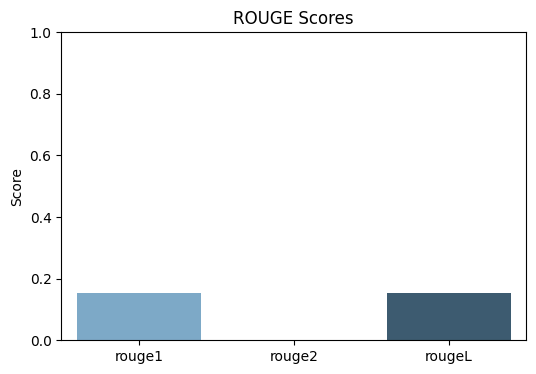

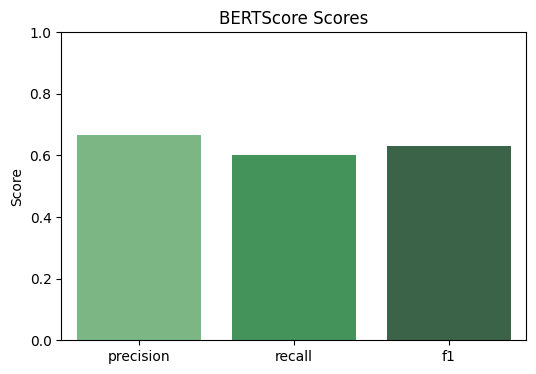

ROUGE 测评结果: {'rouge1': np.float64(0.15384615384615385), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.15384615384615385), 'rougeLsum': np.float64(0.15384615384615385)}
BERTScore 测评结果: {'precision': [0.6662417650222778], 'recall': [0.6009882092475891], 'f1': [0.6319348812103271], 'hashcode': 'bert-base-chinese_L8_no-idf_version=0.3.12(hug_trans=4.57.6)'}


In [18]:
final_answer = run_query_with_react("月读极神的核心机制是什么？")
print("最终答案:\n", final_answer)

reference = """
- 极月读：赋予数名玩家四层的新月下，其余玩家四层的满月下，场地被分割为黑（新月）白（满月）两色的区域，10秒后其中一色会扩散形成月牙形结构。在黑色地板上5秒会获得一层新月下，在白色地板上5秒后会获得一层满月下，并消除异色buff。叠加到五层新月下满月下会被附加15秒的出血和1秒的死亡宣告，在死亡宣告判定前移动到异色地面可以消除死亡宣告。
- 满月流/新月流：月刀左斩/月刀右斩每次发动前会同步发动的圆形/环形AOE。
- 月下缭乱：点名随机1名玩家连续释放初始为4次可分摊的圆形AOE，每释放一次，就会为下一次月下缭乱增加一段伤害，在狂暴前共有三次。
- 破月：点名随机各1名防护治疗和进攻职能玩家释放先后顺序随机的分三次释放不可回避的圆形AOE。
"""

pred_answer = final_answer
rouge_scores = evaluate_answer(pred_answer, reference)
bert_scores = evaluate_answer_bert(pred_answer, reference)

print("ROUGE 测评结果:", rouge_scores)
print("BERTScore 测评结果:", bert_scores)